# Binary Classification Model for MiniBooNE Particle Identification Using Python Take 2
### David Lowe
### January 11, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The MiniBooNE Particle Identification dataset is a classic binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset is taken from the MiniBooNE experiment and is used to distinguish electron neutrinos (signal) from muon neutrinos (background). The data file is set up as follows. In the first line is the number of signal events followed by the number of background events. The records with the signal events come first, followed by the background events. Each line, after the first line, has the 50 particle ID variables for one event.

In iteration Take1, the script focused on evaluating various machine learning algorithms and identifying the model that produces the best overall metrics. Iteration Take1 established the baseline performance for accuracy and processing time.

For this iteration, we will explore the feature selection technique of eliminating collinear features. By eliminating the collinear features, we hope to decrease the processing time while maintaining an acceptable level of accuracy loss.

ANALYSIS: From the previous iteration Take1, the baseline performance of the machine learning algorithms achieved an average accuracy of 90.58%. Two algorithms (Bagged CART and Stochastic Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top overall result and achieved an accuracy metric of 93.95%. By using the optimized parameters, the Stochastic Gradient Boosting algorithm processed the testing dataset with an accuracy of 93.85%, which was just slightly below than the training data.

In the current iteration Take2, the baseline performance of the machine learning algorithms achieved an average accuracy of 90.16%. Two algorithms (Bagged CART and Stochastic Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top overall result and achieved an accuracy metric of 93.92%. By using the optimized parameters, the Stochastic Gradient Boosting algorithm processed the testing dataset with an accuracy of 93.82%, which was just slightly below the training data.

From the model-building perspective, the number of attributes decreased by 13, from 50 down to 37. The processing time went from 7 hours 11 minutes in iteration Take1 down to 6 hours 33 minutes in Take2, which was a reduction of 8.8% from Take1.

CONCLUSION: For this iteration, the Stochastic Gradient Boosting algorithm achieved the best overall results with an improved processing time after eliminating the collinear features. For this dataset, the Stochastic Gradient Boosting algorithm should be considered for further modeling or production use.

Dataset Used: MiniBooNE particle identification Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import smtplib
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

inputFile = 'MiniBooNE_PID.txt'
with open(inputFile) as f:
    first_line = f.readline().strip()
signal_rec = int(first_line.split(" ")[0])
background_rec = int(first_line.split(" ")[1])

widthVector = [14] * 50
colNames = ["attr" + str(i) for i in range(1,51)]
xy_original_df = pd.read_fwf(inputFile, widths=widthVector, header=None, names=colNames, skiprows=1, index_col=False)
xy_original_df['targetVar'] = 0
xy_original_df.iloc[:signal_rec, len(xy_original_df.columns)-1] = 1

In [5]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [6]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [7]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (130064, 51) xy_train_df.shape: (91044, 51)
x_train_df.shape: (91044, 50) y_train_df.shape: (91044,)
x_test_df.shape: (39020, 50) y_test_df.shape: (39020,)


### 1.d) Set up the key parameters to be used in the script

In [8]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [9]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [10]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [11]:
xy_train_df.head(10)

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,targetVar
52564,4.86708,0.860634,81.228300,0.305634,0.009396,0.103407,0.609296,0.807272,3.23882,0.178168,...,-21.566300,0.490841,3.96795,0.000000,0.119104,0.545375,5.77730,2.227230,0.276040,0
68779,5.60083,0.604639,99.057500,0.363930,0.000000,0.155484,0.638794,0.846283,3.18015,0.144571,...,-15.399600,0.788512,2.83190,0.000000,0.301067,0.376953,5.57443,4.400930,0.221756,0
43494,4.60078,1.939510,113.252000,0.202574,0.037333,0.109483,1.253260,0.873827,3.71879,0.213120,...,-6.684130,1.895480,7.79737,0.010667,0.117767,-0.204585,1.06553,1.275370,0.218470,0
23718,3.77414,2.234640,0.205705,0.202561,0.008403,0.499238,1.084260,0.875750,3.35037,0.229166,...,-18.801500,2.098390,6.06755,0.000000,0.121810,0.241722,1.23351,0.483625,0.236298,1
81187,5.80713,1.843250,127.534000,0.270716,0.000000,0.143069,0.623443,0.730312,3.53536,0.141951,...,-32.229900,1.983500,7.62465,0.000000,0.201957,0.049204,2.57725,1.915970,0.251853,0
44257,5.14600,1.294190,184.581000,0.290387,0.027539,0.106780,1.094510,0.854798,3.51259,0.156955,...,39.839400,1.348850,3.36308,0.000000,0.200896,-0.058993,3.78978,0.877358,0.299672,0
69849,4.65700,0.901575,104.821000,0.334642,0.002845,0.160581,0.835746,0.814116,3.27704,0.166619,...,0.753716,-0.033585,2.65568,0.000000,0.074433,0.640281,4.48684,1.931510,0.348951,0
113760,5.46400,1.751280,164.273000,0.274584,0.007194,0.115741,0.545271,0.843306,3.45759,0.136201,...,23.968800,-0.060281,5.37249,0.001799,0.129124,-0.147815,3.00475,0.443174,0.253147,0
13501,3.56633,0.579775,44.543500,0.232389,0.012535,0.297419,1.657260,0.921669,3.14465,0.149618,...,32.300500,0.800309,3.59400,0.000000,0.151860,0.038811,1.22633,0.953518,0.309013,1
30561,3.61375,0.913554,61.505000,0.245354,0.022255,0.374136,0.818520,0.841284,3.43856,0.192682,...,-9.382560,0.452332,7.59804,0.004451,0.083918,-0.008287,1.22240,-0.084620,0.294379,1


#### 2.a.ii) Dimensions of the dataset.

In [12]:
xy_train_df.shape

(91044, 51)

#### 2.a.iii) Types of the attributes.

In [13]:
xy_train_df.dtypes

attr1        float64
attr2        float64
attr3        float64
attr4        float64
attr5        float64
attr6        float64
attr7        float64
attr8        float64
attr9        float64
attr10       float64
attr11       float64
attr12       float64
attr13       float64
attr14       float64
attr15       float64
attr16       float64
attr17       float64
attr18       float64
attr19       float64
attr20       float64
attr21       float64
attr22       float64
attr23       float64
attr24       float64
attr25       float64
attr26       float64
attr27       float64
attr28       float64
attr29       float64
attr30       float64
attr31       float64
attr32       float64
attr33       float64
attr34       float64
attr35       float64
attr36       float64
attr37       float64
attr38       float64
attr39       float64
attr40       float64
attr41       float64
attr42       float64
attr43       float64
attr44       float64
attr45       float64
attr46       float64
attr47       float64
attr48       

#### 2.a.iv) Statistical summary of all attributes.

In [14]:
xy_train_df.describe()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr42,attr43,attr44,attr45,attr46,attr47,attr48,attr49,attr50,targetVar
count,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,...,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000,91044.000000
mean,1.391106,-1.970835,123.337980,-3.174293,-3.447098,-3.296162,-2.489190,-2.635333,-0.016491,-3.283198,...,-25.041934,-2.725933,2.549636,-3.447341,-3.278233,-3.615110,-0.609532,-1.848610,-3.226633,0.281336
std,58.957439,58.754146,191.985335,58.677034,58.660931,58.669951,58.718363,58.708804,58.863637,58.670604,...,66.587218,58.716034,59.192568,58.660923,58.670935,58.658967,58.859173,58.787960,58.673944,0.449654
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,4.010237,0.878174,49.292050,0.241517,0.001149,0.085293,0.716196,0.783316,3.284438,0.142823,...,-40.021625,-0.028957,3.418488,0.000000,0.122059,-0.343547,1.419810,0.273296,0.197139,0.000000
50%,4.788315,1.380675,106.191500,0.272096,0.005008,0.141254,0.923609,0.833889,3.427510,0.170494,...,-21.623350,0.460773,4.766460,0.000000,0.168646,0.040980,2.363050,1.116180,0.231220,0.000000
75%,5.626753,1.944955,138.927000,0.315121,0.013158,0.212916,1.181212,0.874351,3.586525,0.199953,...,-3.275228,1.153845,6.864593,0.001996,0.224936,0.293494,3.773808,2.280382,0.263120,1.000000
max,17.057300,8.606240,4747.670000,0.736804,0.179012,0.703859,6.241080,0.982981,6.992290,0.524888,...,150.445000,43.651200,85.823100,0.446914,0.605667,1.826370,21.768200,25.423300,0.625484,1.000000


#### 2.a.v) Count missing values.

In [15]:
xy_train_df.isnull().sum()

attr1        0
attr2        0
attr3        0
attr4        0
attr5        0
attr6        0
attr7        0
attr8        0
attr9        0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
attr31       0
attr32       0
attr33       0
attr34       0
attr35       0
attr36       0
attr37       0
attr38       0
attr39       0
attr40       0
attr41       0
attr42       0
attr43       0
attr44       0
attr45       0
attr46       0
attr47       0
attr48       0
attr49       0
attr50       0
targetVar    0
dtype: int64

#### 2.a.vi) Summarize the levels of the class attribute.

In [16]:
xy_train_df.groupby('targetVar').size()

targetVar
0    65430
1    25614
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

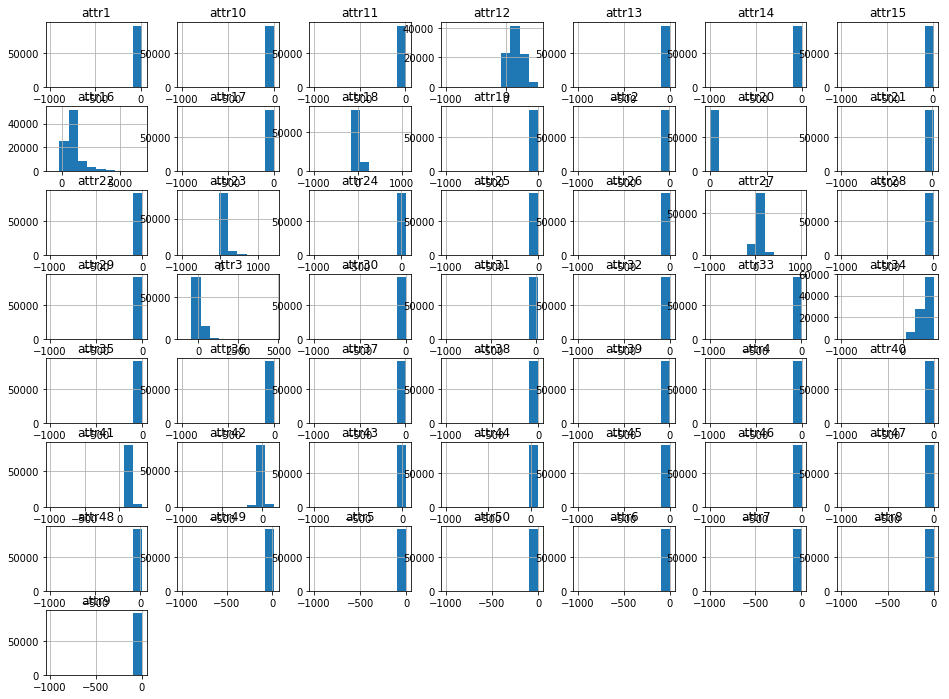

In [17]:
# Histograms for each attribute
x_train_df.hist()
pyplot.show()

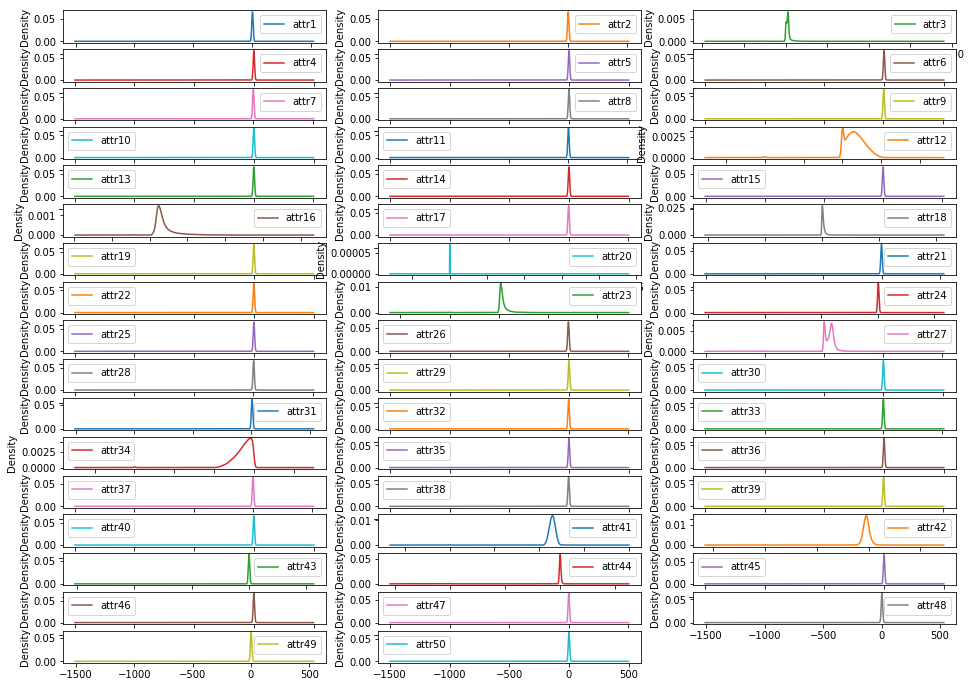

In [18]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

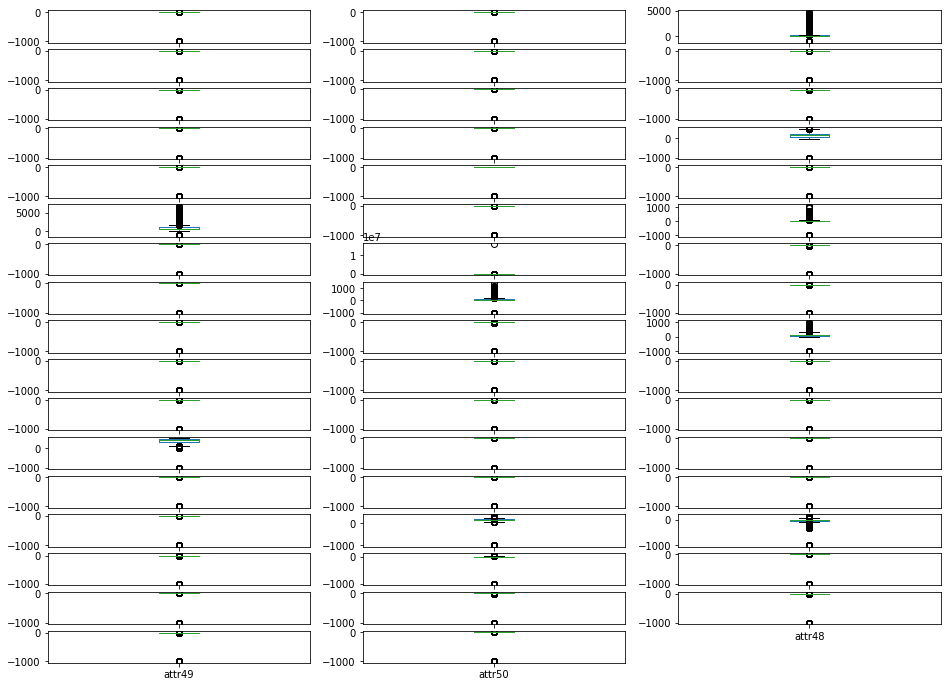

In [19]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [20]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

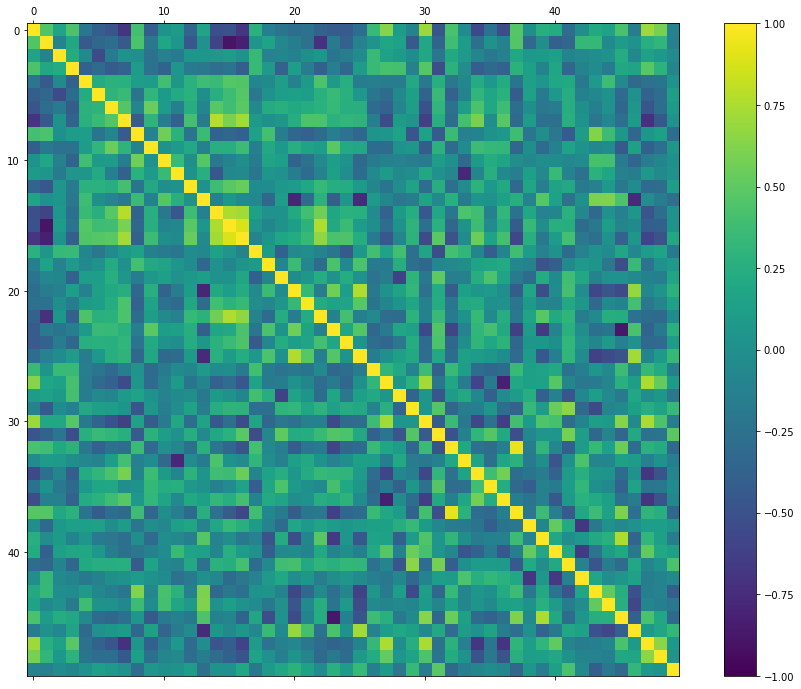

In [21]:
# Correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='spearman')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [22]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [23]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [24]:
# Not applicable for this iteration of the project.

### 3.b) Feature Selection

In [25]:
def findCorrelated(corrmat, cutoff = 0.75):    

### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# args:
    # corrmat: a correlation matrix
    # cutoff: pairwise absolute correlation cutoff
# returns:
    # variables to removed

    if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
    averageCorr = corrmat.abs().mean(axis = 1)

    # set lower triangle and diagonal of correlation matrix to NA
    for row in range(0, len(corrmat)):
        for col in range(0, (row+1)):
            corrmat.iloc[row, col] = None

    # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
    to_delete = list()
    for col in range(0, len(corrmat.columns)):
        for row in range(0, len(corrmat)):
            if(abs(corrmat.iloc[row, col]) > cutoff):
                if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
                else: to_delete.append(col)

    to_delete = list(set(to_delete))
    return to_delete

In [26]:
# By using the calculated correlation matrix, find the collinear features
collinear = findCorrelated(correlations, cutoff = 0.75)
print('Number of attributes to be removed:', len(collinear))
dropAttributes = x_train_df.columns[collinear]
print('Columns to be removed:')
print(dropAttributes)

Number of attributes to be removed: 13
Columns to be removed:
Index(['attr34', 'attr38', 'attr8', 'attr46', 'attr15', 'attr16', 'attr17',
       'attr14', 'attr48', 'attr21', 'attr24', 'attr26', 'attr28'],
      dtype='object')


In [27]:
# Drop the highly collinear features
x_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
x_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 3.c) Data Transforms

In [28]:
# Not applicable for this iteration of the project.

### 3.d) Display the Final Datasets for Model-Building

In [29]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (91044, 37) y_train.shape: (91044,)
x_test.shape: (39020, 37) y_test.shape: (39020,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, three non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART), k-Nearest Neighbors, and Support Vector Machine

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Stochastic Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [30]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [31]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression(random_state=seedNum)))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('BT', BaggingClassifier(random_state=seedNum)))
models.append(('RF', RandomForestClassifier(random_state=seedNum)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
results = []
names = []
metrics = []

In [32]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22

LR: 0.864352 (0.029611)
Model training time: 0:01:50.018010
CART: 0.888856 (0.003396)
Model training time: 0:01:13.749902
KNN: 0.872402 (0.003182)
Model training time: 0:01:05.824098
BT: 0.922334 (0.001966)
Model training time: 0:07:06.542411


C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-package

RF: 0.920181 (0.002423)
Model training time: 0:01:03.530175


C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-package

ET: 0.917469 (0.003765)
Model training time: 0:00:13.130884
GBM: 0.926025 (0.002880)
Model training time: 0:05:40.883758
Average metrics (accuracy) from all models: 0.9016598957154949


### 4.b) Spot-checking baseline algorithms

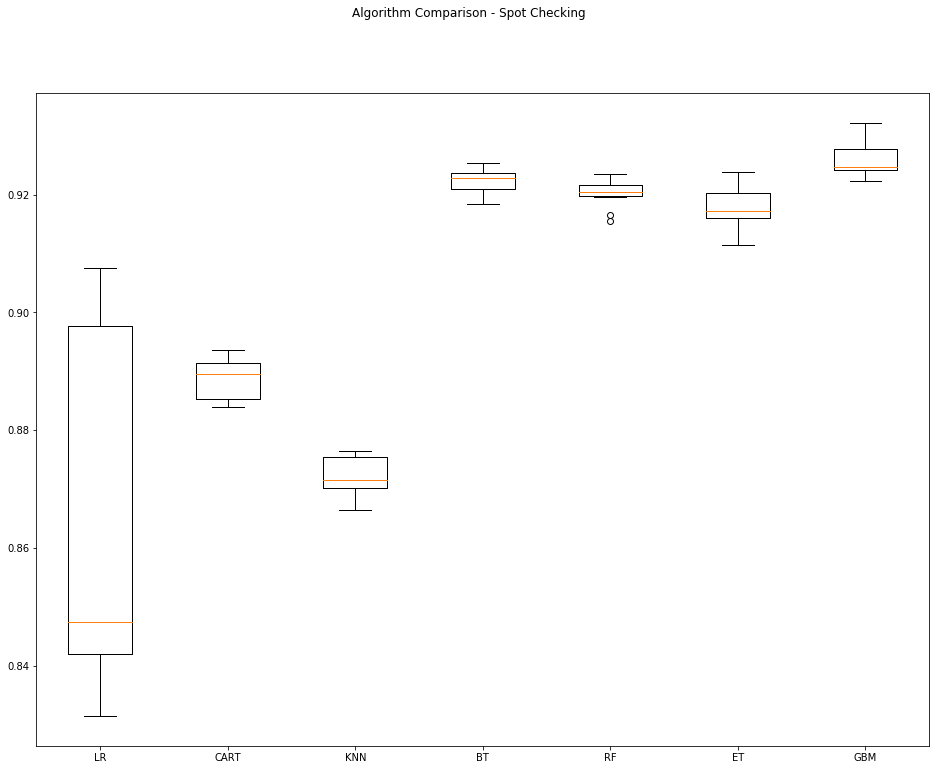

In [33]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [34]:
# Set up the comparison array
results = []
names = []

In [35]:
# Tuning algorithm #1 - Bagged CART
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([10,30,50,70,90]))
model1 = BaggingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BT')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.931846 using {'n_estimators': 70}
0.922334 (0.001966) with: {'n_estimators': 10}
0.929353 (0.003303) with: {'n_estimators': 30}
0.931198 (0.002559) with: {'n_estimators': 50}
0.931846 (0.002830) with: {'n_estimators': 70}
0.931692 (0.002696) with: {'n_estimators': 90}
Model training time: 3:04:58.447004


In [36]:
# Tuning algorithm #2 - Stochastic Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([200,400,600,800,1000]))
model2 = GradientBoostingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.939271 using {'n_estimators': 1000}
0.931451 (0.002792) with: {'n_estimators': 200}
0.935745 (0.002576) with: {'n_estimators': 400}
0.937602 (0.002476) with: {'n_estimators': 600}
0.938678 (0.002726) with: {'n_estimators': 800}
0.939271 (0.002404) with: {'n_estimators': 1000}
Model training time: 2:51:19.940316


### 5.b) Compare Algorithms After Tuning

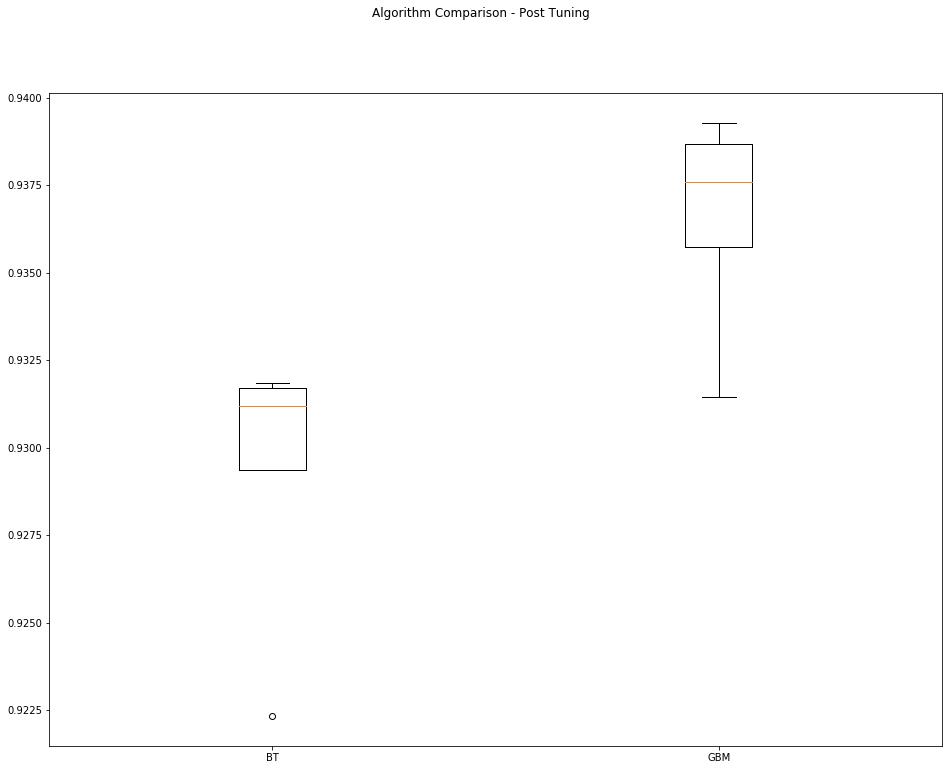

In [37]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [38]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [39]:
model = GradientBoostingClassifier(n_estimators=1000, random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9382111737570477
[[26838  1297]
 [ 1114  9771]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     28135
           1       0.88      0.90      0.89     10885

   micro avg       0.94      0.94      0.94     39020
   macro avg       0.92      0.93      0.92     39020
weighted avg       0.94      0.94      0.94     39020



### 6.b) Create standalone model on entire training dataset

In [40]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = GradientBoostingClassifier(n_estimators=1000, random_state=seedNum)
finalModel.fit(x_complete, y_complete)

x_complete.shape: (130064, 37) y_complete.shape: (130064,)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=888,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### 6.c) Save model for later use

In [41]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [42]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 6:33:04.937586
